# [1] Defining the nature and scope of the project

The data is provided to us by MSKCC (Memorial Sloan Kettering Cancer Center).

For a cancer tumour, there can be multiple genetic mutations possible, but the most difficult part is to separate the driver-mutations which contribute the most to the tumour growth. This task is currently done by a pathologist who manually reviews and categorises each genetic mutation using data based on based on evidence from text-based clinical literature. This process costs a huge amount of time and other resources. Our task is to build a Machine Learning model which helps us classify the genetic mutations, thus making it faster to find the right genetic mutation and treat the patients faster and accurately.

This project will compare different classifier models with a range of parameters and then pick the best model and parameter based on grid search with cross validation. Finally we will train, predict and evaluate using the best model.

## [2] Importing Necessary Libraries

In [1]:
# Time count
from time import time
from datetime import datetime
start=time()

# Basics
import pandas as pd
import numpy as np
import pickle

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from prettytable import PrettyTable

# Text-Processing
from bs4 import BeautifulSoup
from wordcloud import WordCloud,STOPWORDS
import re
from tqdm import tqdm
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Pre-processing
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
#from mlxtend.classifier import StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Hypertuning
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_predict

# Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, log_loss

# Warnings
import warnings
warnings.filterwarnings("ignore")

## [3] Loading and Exploring Dataset

In [2]:
# loading datasets
train_variants_df = pd.read_csv("training_variants")
test_variants_df = pd.read_csv("test_variants")
train_text_df = pd.read_csv("training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text_df = pd.read_csv("test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

In [3]:
# checking shapes
print("Train Variant".ljust(15), train_variants_df.shape)
print("Train Text".ljust(15), train_text_df.shape)
print("Test Variant".ljust(15), test_variants_df.shape)
print("Test Text".ljust(15), test_text_df.shape)

Train Variant   (3321, 4)
Train Text      (3321, 2)
Test Variant    (5668, 3)
Test Text       (5668, 2)


In [4]:
train_variants_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
test_variants_df.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [6]:
train_variants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [7]:
unique_genes = train_variants_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])

# Top 10 most frequent genes
print(unique_genes.head(10))

Number of Unique Genes : 264
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ALK        69
ERBB2      69
PDGFRA     60
Name: Gene, dtype: int64


In [8]:
unique_variations = train_variants_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])

# Top 10 most frequent variations
print(unique_variations.head(10))

Number of Unique Variations : 2996
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
Q61L                     3
E17K                     3
T58I                     3
Q61R                     3
Name: Variation, dtype: int64


In [9]:
test_variants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5668 entries, 0 to 5667
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         5668 non-null   int64 
 1   Gene       5668 non-null   object
 2   Variation  5668 non-null   object
dtypes: int64(1), object(2)
memory usage: 133.0+ KB


In [10]:
print("For training data, there are a total of:")
print(len(train_variants_df.ID.unique()), "IDs")
print(len(train_variants_df.Gene.unique()), "unique genes")
print(len(train_variants_df.Variation.unique()), "unique variations and ")
print(len(train_variants_df.Class.unique()),  "classes")

For training data, there are a total of:
3321 IDs
264 unique genes
2996 unique variations and 
9 classes


In [11]:
train_text_df.head(10)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
5,5,Oncogenic mutations in the monomeric Casitas B...
6,6,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL is a negative regulator of activated recep...
8,8,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,Abstract Juvenile myelomonocytic leukemia (JM...


In [12]:
train_variants_df.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

In [13]:
train_text_df.loc[:, 'Text_count']  = train_text_df["Text"].apply(lambda x: len(str(x).split()))
train_text_df.head()

,ID,Text,Text_count
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,6089
1,1,Abstract Background Non-small cell lung canc...,5756
2,2,Abstract Background Non-small cell lung canc...,5756
3,3,Recent evidence has demonstrated that acquired...,5572
4,4,Oncogenic mutations in the monomeric Casitas B...,6202


In [14]:
# train_text_df.Text.values

In [15]:
# Merging the two data sets

train_df = pd.merge(train_variants_df, train_text_df, on='ID')

In [16]:
train_df.head()

,ID,Gene,Variation,Class,Text,Text_count
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,5756
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,5756
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,5572
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,6202


In [17]:
count_grp = train_df.groupby('Class')["Text_count"]
count_grp.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
1,568.0,9450.299296,6516.412101,1.0,4973.0,7305.0,12873.5,52972.0
2,452.0,9310.393805,7627.288722,116.0,4185.0,6810.0,12220.0,61957.0
3,89.0,6757.382022,3725.366918,1737.0,4283.0,5572.0,7415.0,27391.0
4,686.0,8983.390671,7280.220754,53.0,4566.0,6351.0,11537.0,43913.0
5,242.0,7517.049587,3902.868040,183.0,5245.0,6463.0,9513.5,24226.0
6,275.0,7184.120000,3836.912865,1.0,4505.5,6587.0,7847.0,24609.0
7,953.0,11442.867786,10111.940846,1.0,4871.0,8254.0,14620.0,76782.0
8,19.0,10814.421053,5648.714095,2111.0,5586.0,11253.0,15535.0,20626.0
9,37.0,12807.459459,10217.093429,1147.0,4942.0,10930.0,15797.0,45177.0


In [18]:
# We can see there are some entries with text count of 1. Lets have a look at those entries

train_df[train_df["Text_count"]==1.0]

,ID,Gene,Variation,Class,Text,Text_count
1109,1109,FANCA,S1088F,1,NaN,1
1277,1277,ARID5B,Truncating Mutations,1,NaN,1
1407,1407,FGFR3,K508M,6,NaN,1
1639,1639,FLT1,Amplification,6,NaN,1
2755,2755,BRAF,G596C,7,NaN,1


In [19]:
# Filling those null text with the help of gene and variation text

train_df.loc[train_df['Text'].isnull(),'Text'] = train_df['Gene'] + ' ' + train_df['Variation']
train_df[train_df['ID']==1109]

,ID,Gene,Variation,Class,Text,Text_count
1109,1109,FANCA,S1088F,1,FANCA S1088F,1


In [20]:
# # Making a singlle combined text column to process

# train_df["Combined_text"]=train_df["Gene"]+" "+train_df["Variation"]+" "+train_df["Text"]

In [21]:
train_df

,ID,Gene,Variation,Class,Text,Text_count
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,5756
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,5756
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,5572
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,6202
...,...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...,11028
3317,3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...,6068
3318,3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...,5122
3319,3319,RUNX1,R80C,4,The RUNX1/AML1 gene is the most frequent targe...,4885


## [4] Data Visualization

<AxesSubplot:xlabel='Class', ylabel='count'>

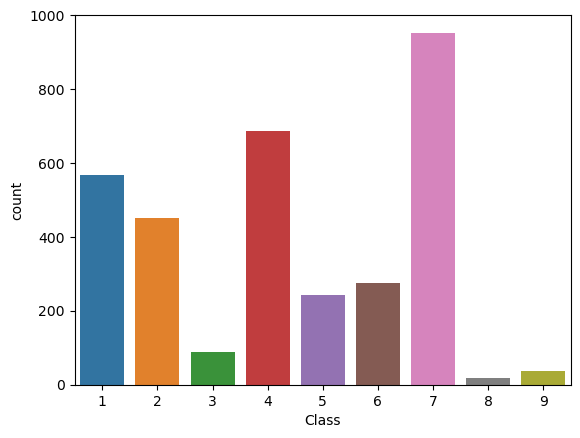

In [22]:
sns.countplot(x='Class',data=train_df)

In [23]:
# df.dropna(inplace=True)

*** Observations ***
1) Classes seem very imbalanced

2) The dataset is imbalanced in nature. We have most data points for class 7 and least for class 8.

3) Probability of a particular gene being one of the first four most commonly occuring genes is more than 50%.

4) BRCA1 ALK TSC2 are the most commonly occuring Genes.

## [5] Preprocessing Data

In [24]:
df=train_df[['Class','Text']].dropna()


In [25]:
df

,Class,Text
0,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,2,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
...,...,...
3316,4,Introduction Myelodysplastic syndromes (MDS) ...
3317,1,Introduction Myelodysplastic syndromes (MDS) ...
3318,1,The Runt-related transcription factor 1 gene (...
3319,4,The RUNX1/AML1 gene is the most frequent targe...


In [26]:
df.shape

(3321, 2)

In [27]:

def create_cloud(string, title=None):
    cloud = WordCloud(height=1080, 
                      width=1920, 
                      background_color='white', 
                      min_font_size=10, 
                      stopwords=STOPWORDS).generate(string)
    plt.figure(figsize=(10,20))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    if title:
        plt.title(title, fontdict={'fontsize':24})
    plt.show()

In [28]:
def text_processing(data):
    
    def decontracted(phrase):
        # specific
        phrase= re.sub(r'<br /><br />',' ',phrase)
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r'"', " ", phrase)
        return phrase
    stopwords=set(STOPWORDS)

    # Combining all the above stundents 
   
    preprocessed_reviews = []
    # tqdm is for printing the status bar
    
    for sentance in tqdm(data['Text'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e not in stopwords)
        preprocessed_reviews.append(sentance.strip())
    

    porter = PorterStemmer()
    list2=[]
    for  sentence in preprocessed_reviews:
      list1=[]
      for words in sentence.split():
        list1.append(porter.stem(words))

      list2.append(' '.join(list1))
    return(list2)

In [29]:
%%time
x=text_processing(df)

100%|██████████████████████████████████████████████████████████████████████████████| 3321/3321 [00:55<00:00, 59.32it/s]


Wall time: 7min 49s


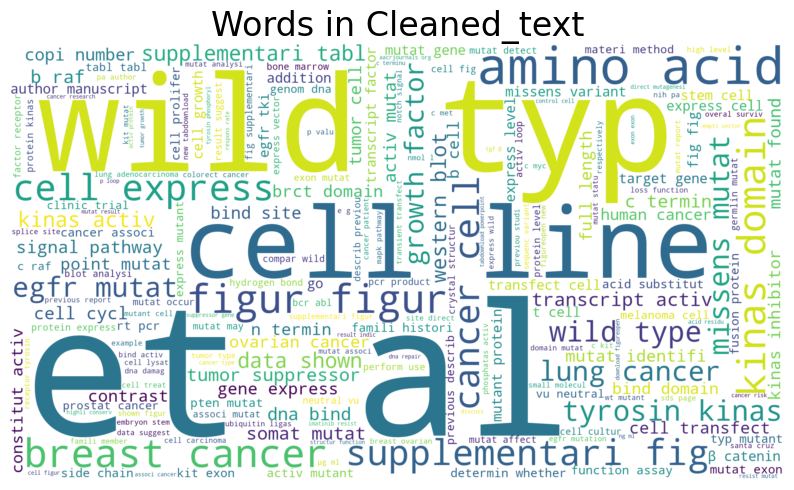

Wall time: 1min 20s


In [30]:
%%time
create_cloud(' '.join(x).lower(),'Words in Cleaned_text')

In [31]:
df['Cleaned_text']=x
# # Making a singlle combined text column to process

df["Combined_text"]=train_df["Gene"]+" "+train_df["Variation"]+" "+df["Cleaned_text"]
df

,Class,Text,Cleaned_text,Combined_text
0,1,Cyclin-dependent kinases (CDKs) regulate a var...,cyclin-depend kinas (cdks) regul varieti funda...,FAM58A Truncating Mutations cyclin-depend kina...
1,2,Abstract Background Non-small cell lung canc...,abstract background non-smal cell lung cancer ...,CBL W802* abstract background non-smal cell lu...
2,2,Abstract Background Non-small cell lung canc...,abstract background non-smal cell lung cancer ...,CBL Q249E abstract background non-smal cell lu...
3,3,Recent evidence has demonstrated that acquired...,recent evid demonstr acquir uniparent disomi (...,CBL N454D recent evid demonstr acquir uniparen...
4,4,Oncogenic mutations in the monomeric Casitas B...,oncogen mutat monomer casita b-lineag lymphoma...,CBL L399V oncogen mutat monomer casita b-linea...
...,...,...,...,...
3316,4,Introduction Myelodysplastic syndromes (MDS) ...,introduct myelodysplast syndrom (mds) heteroge...,RUNX1 D171N introduct myelodysplast syndrom (m...
3317,1,Introduction Myelodysplastic syndromes (MDS) ...,introduct myelodysplast syndrom (mds) heteroge...,RUNX1 A122* introduct myelodysplast syndrom (m...
3318,1,The Runt-related transcription factor 1 gene (...,the runt-rel transcript factor gene alias belo...,RUNX1 Fusions the runt-rel transcript factor g...
3319,4,The RUNX1/AML1 gene is the most frequent targe...,the gene frequent target chromosom transloc le...,RUNX1 R80C the gene frequent target chromosom ...


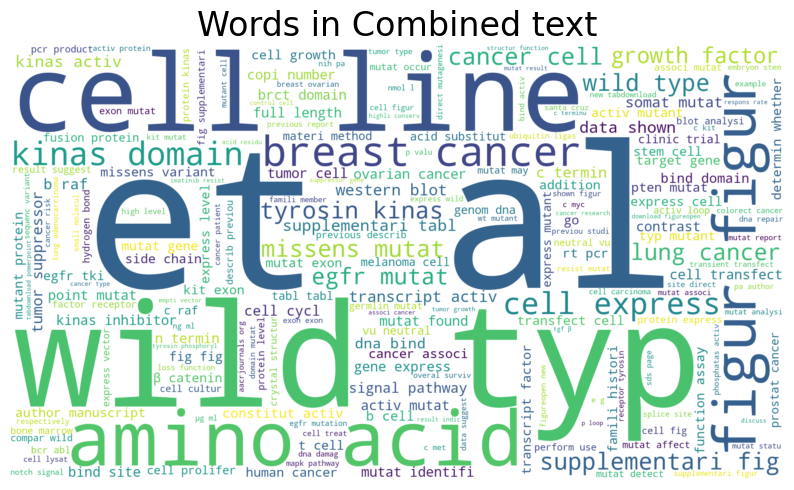

Wall time: 1min 35s


In [32]:
%%time
comb_text=df['Combined_text']
create_cloud(' '.join(comb_text).lower(),'Words in Combined text')

## [6] Splitting

In [33]:
# Split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]

y = df['Class']
X = df['Combined_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=19)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2490,), (831,), (2490,), (831,))

## [7] Vectorizing Data to create Bag of Words

In [35]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)


In [36]:
X_train_bow.shape, X_test_bow.shape

((2490, 71702), (831, 71702))

## [8] Converting vectorized data to array

In [37]:
X_train_bow = X_train_bow.toarray()
X_test_bow = X_test_bow.toarray()

In [38]:
type(X_train_bow), type(X_test_bow), type (y_train), type(y_test)

(numpy.ndarray,
 numpy.ndarray,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [39]:
X_train_bow.shape, X_test_bow.shape

((2490, 71702), (831, 71702))

## [9] Function to compare different models

In [40]:
%%time
# List of models to try
models = [#OneVsRestClassifier(),
          #XGBClassifier(),
          LGBMClassifier(),
          KNeighborsClassifier(),
          GaussianNB(),
          MultinomialNB(),
          LogisticRegression(),
          RandomForestClassifier(),
          DecisionTreeClassifier(),
          #GradientBoostingClassifier(),
         ]

# Hyperparameters to try
param_grid = {#'OneVsRestClassifier' : {},
              #'XGBClassifier' : {'n_estimators': [100, 200], 'max_depth': [3, 5, 70, 85], 'objective': ['multi:softprob'], 'learning_rate' :[0.1, 0.5, 1]},
              'LGBMClassifier': {'max_depth': [3, 5, 70, 85], 'learning_rate' :[0.1, 0.5, 1]},
              'KNeighborsClassifier': {'n_neighbors': [10,12,14,16,18,20,22,24,26,28,30]},
              'GaussianNB': {'var_smoothing': [.00001,.0001,.001,0.01,0.1,1,10]},
              'MultinomialNB' : {'alpha': [.00001,.0001,.001,0.01,0.1,1,10]},
              'LogisticRegression':{'C': [.00001,.0001,.001,0.01,0.1,1,10]},
              'RandomForestClassifier': {'n_estimators': [100, 200], 'max_depth': [80,90],'max_features': [2, 3]},
              'DecisionTreeClassifier': {'max_depth': [3, 5, 70,85]},
              #'GradientBoostingClassifier': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.5, 1]},
             }


# Dataframe to store results
metrics = {'Model': [], 'ATR': [], 'ATS': [], 'F1_TR': [], 'F1_TS': [], 'TIME': [], 'B_P': [],}

# Looping through models
for i, model in enumerate(models):
    mst = time()
    
    # Get model name
    model_name = str(model).replace("()","")
    # model_names.append(model_name)
    
    # Perform grid search with cross-validation
    gs = GridSearchCV(estimator=model, param_grid=param_grid[model_name],scoring="accuracy", cv=5, n_jobs =-1)
    gs.fit(X_train_bow, y_train)
    
#     gs = BayesSearchCV(estimator=model, search_spaces=search_spaces[model_name], cv=5, n_jobs =-1)
#     gs.fit(X_train_bow, y_train)
    
    # Get best parameters
    best_params = gs.best_params_
    print(f"Best Paramenters for {model_name} is {best_params}")

    # Fit model with best parameters
    model.set_params(**best_params)
    model.fit(X_train_bow, y_train)
    
    # Append in a list for future use
    # basic_models.append(model)
    
    # Make predictions
    y_pred_train = model.predict(X_train_bow)
    y_pred_test = model.predict(X_test_bow)

    # Calculate metrics
    accuracy_train = accuracy_score(y_pred_train,y_train)
    accuracy_test = accuracy_score(y_pred_test,y_test)
    f1_train = f1_score(y_pred_train,y_train,average='weighted')
    f1_test = f1_score(y_pred_test,y_test,average='weighted')
    
    # Calculate run time for model
    met = time()
    mrt = met-mst
    minute=int(mrt/60)
    second=mrt%60
        
    # Append to DataFrame
    metrics['Model'].append(model_name)    
    metrics['ATR'].append(f"{accuracy_train:.3f}")
    metrics['ATS'].append(f"{accuracy_test:.3f}")
    metrics['F1_TR'].append(f"{f1_train:.3f}")
    metrics['F1_TS'].append(f"{f1_test:.3f}")
    metrics['TIME'].append(f"{mrt:.3f}")
    metrics['B_P'].append(best_params)
    
    metrics_df = pd.DataFrame(metrics)
    

    print(f"{model.__class__.__name__}: accuracy_train={accuracy_train:.4f} accuracy_test={accuracy_test:.4f} f1_train={f1_train:.4f}, f1_test = {f1_test:.4f}")
    
    if minute>=60:
        hour=int(minute/60)
        minute=minute%60
        print(f"Total execution time for {model.__class__.__name__} is : {mrt}'.")
        print(f"Which translates to: {hour} hours {minute} minutes and {second:.3f} seconds.")
    else:
        print(f"Total execution time for {model.__class__.__name__} is : {mrt}'.")
        print(f"Which translates to: {minute} minutes and {second:.3f} seconds.")
    print()

Best Paramenters for LGBMClassifier is {'learning_rate': 0.1, 'max_depth': 70}
LGBMClassifier: accuracy_train=0.9072 accuracy_test=0.6811 f1_train=0.9091, f1_test = 0.6876
Total execution time for LGBMClassifier is : 681.7496411800385'.
Which translates to: 11 minutes and 21.750 seconds.

Best Paramenters for KNeighborsClassifier is {'n_neighbors': 10}
KNeighborsClassifier: accuracy_train=0.6253 accuracy_test=0.5560 f1_train=0.6340, f1_test = 0.5645
Total execution time for KNeighborsClassifier is : 567.4277055263519'.
Which translates to: 9 minutes and 27.428 seconds.

Best Paramenters for GaussianNB is {'var_smoothing': 1e-05}
GaussianNB: accuracy_train=0.5984 accuracy_test=0.4320 f1_train=0.5489, f1_test = 0.4018
Total execution time for GaussianNB is : 217.40614676475525'.
Which translates to: 3 minutes and 37.406 seconds.

Best Paramenters for MultinomialNB is {'alpha': 1e-05}
MultinomialNB: accuracy_train=0.7964 accuracy_test=0.6065 f1_train=0.7912, f1_test = 0.6025
Total executi

## [10] Representing the findings in a table and sorting out the best model with parameters

In [41]:
# Create a PrettyTable object
table = PrettyTable()

# Add columns to the table
table.add_column("Model Name", metrics['Model'])
table.add_column("Accu_train",metrics['ATR'])
table.add_column("Accu_test",metrics['ATS'])
table.add_column("F1_train",metrics['F1_TR'])
table.add_column("F1_test",metrics['F1_TS'])
table.add_column("Time",metrics['TIME'])
table.add_column("Best parameters",metrics['B_P'])

# Set the alignment of the columns
# table.align["Model"] = "l"
# table.align["MAE"] = "r"
# table.align["MSE"] = "r"
# table.align["R2"] = "r"
# table.align["Adjusted R2"] = "r"

print(table)

+------------------------+------------+-----------+----------+---------+----------+-----------------------------------------------------------+
|       Model Name       | Accu_train | Accu_test | F1_train | F1_test |   Time   |                      Best parameters                      |
+------------------------+------------+-----------+----------+---------+----------+-----------------------------------------------------------+
|     LGBMClassifier     |   0.907    |   0.681   |  0.909   |  0.688  | 681.750  |          {'learning_rate': 0.1, 'max_depth': 70}          |
|  KNeighborsClassifier  |   0.625    |   0.556   |  0.634   |  0.565  | 567.428  |                    {'n_neighbors': 10}                    |
|       GaussianNB       |   0.598    |   0.432   |  0.549   |  0.402  | 217.406  |                  {'var_smoothing': 1e-05}                 |
|     MultinomialNB      |   0.796    |   0.606   |  0.791   |  0.603  | 149.453  |                      {'alpha': 1e-05}               

In [42]:
best=metrics_df.sort_values(by = ['ATR','F1_TR'], ascending=False).set_index('Model')
print(best)
print()
print(f"Best Model is : \033[1m{best.index[0]}\033[0m with the best parameters : \033[1m{best.iloc[0,-1]}\033[0m")

                          ATR    ATS  F1_TR  F1_TS      TIME  \
Model                                                          
DecisionTreeClassifier  1.000  0.578  1.000  0.580   206.887   
RandomForestClassifier  0.998  0.626  0.998  0.639   509.403   
LGBMClassifier          0.907  0.681  0.909  0.688   681.750   
LogisticRegression      0.804  0.640  0.812  0.643  3457.969   
MultinomialNB           0.796  0.606  0.791  0.603   149.453   
KNeighborsClassifier    0.625  0.556  0.634  0.565   567.428   
GaussianNB              0.598  0.432  0.549  0.402   217.406   

                                                                      B_P  
Model                                                                      
DecisionTreeClassifier                                  {'max_depth': 85}  
RandomForestClassifier  {'max_depth': 80, 'max_features': 3, 'n_estima...  
LGBMClassifier                    {'learning_rate': 0.1, 'max_depth': 70}  
LogisticRegression                         

## [11] Finalizing the model with best results

In [43]:
%%time
final = LGBMClassifier()
final.set_params(**{'learning_rate': 0.1, 'max_depth': 70})
final.fit(X_train_bow, y_train)

y_pred_train =final.predict(X_train_bow)
y_pred_test = final.predict(X_test_bow)

Wall time: 40.7 s


## [12] Inference

In [44]:
# saving model to disk

model_filename='GridSearch_Combined_after_cleaning_full_data.pkl'
pickle.dump(final, open(model_filename, 'wb'))

# label_filename='label_encoder.pkl'
# pickle.dump(le, open(label_filename, 'wb'))

## [13] Classification Report

In [45]:
y_train.value_counts()

7    715
4    514
1    426
2    339
6    206
5    181
3     67
9     28
8     14
Name: Class, dtype: int64

In [46]:
print(classification_report(y_pred_train,y_train,target_names=['Class 1','Class 2','Class 3','Class 4','Class 5','Class 6','Class 7','Class 8','Class 9']))

              precision    recall  f1-score   support

     Class 1       0.88      0.89      0.89       421
     Class 2       0.93      0.97      0.95       325
     Class 3       0.51      0.68      0.58        50
     Class 4       0.96      0.91      0.94       542
     Class 5       0.71      0.78      0.74       166
     Class 6       0.88      0.94      0.91       194
     Class 7       0.97      0.92      0.94       753
     Class 8       0.93      1.00      0.96        13
     Class 9       0.93      1.00      0.96        26

    accuracy                           0.91      2490
   macro avg       0.86      0.90      0.87      2490
weighted avg       0.91      0.91      0.91      2490



In [47]:
print(classification_report(y_pred_test,y_test,target_names=['Class 1','Class 2','Class 3','Class 4','Class 5','Class 6','Class 7','Class 8','Class 9']))

              precision    recall  f1-score   support

     Class 1       0.58      0.68      0.62       121
     Class 2       0.52      0.60      0.56        98
     Class 3       0.59      0.43      0.50        30
     Class 4       0.80      0.69      0.74       200
     Class 5       0.36      0.50      0.42        44
     Class 6       0.68      0.89      0.77        53
     Class 7       0.83      0.72      0.77       276
     Class 8       0.20      1.00      0.33         1
     Class 9       0.78      0.88      0.82         8

    accuracy                           0.68       831
   macro avg       0.59      0.71      0.62       831
weighted avg       0.71      0.68      0.69       831



## [14] Confusion Matrix

<AxesSubplot:>

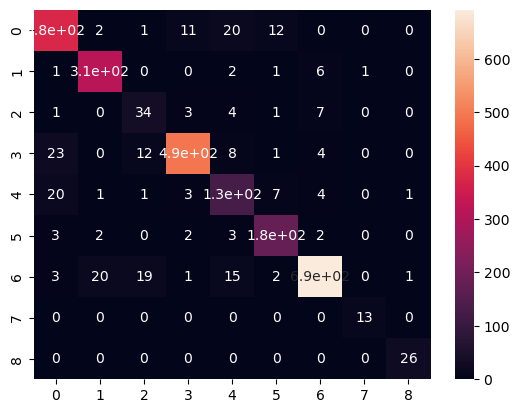

In [48]:
c= confusion_matrix(y_pred_train, y_train)
sns.heatmap(c, annot=True)

<AxesSubplot:>

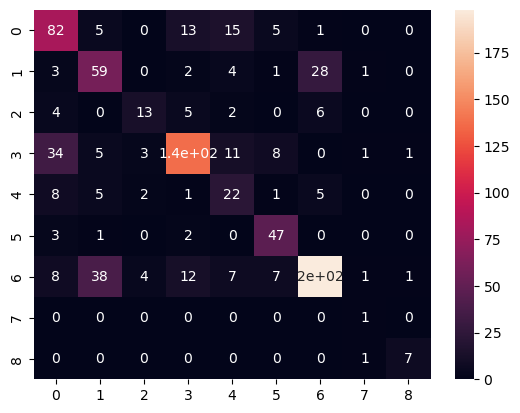

In [49]:
c= confusion_matrix(y_pred_test, y_test)
sns.heatmap(c, annot=True)

## [15] Total Run-time

In [50]:
end=time()
total_time=end-start
minute=int(total_time/60)
second=total_time%60
if minute>=60:
    hour=int(minute/60)
    minute=minute%60
    print('Total execution time is : {}'.format(total_time))
    print(f"Which translates to: {hour} hours {minute} minutes and {second:.3f} seconds.")
else:
    print('Total execution time is : {}'.format(total_time))
    print(f"Which translates to: {minute} minutes and {second:.3f} seconds.")

Total execution time is : 6513.8008716106415
Which translates to: 1 hours 48 minutes and 33.801 seconds.


## [16] Conclusion and Summary

1) The evaluation results show that the DecisionTreeClassifier with parameters {'max_depth': 86} gives the best result for 10000 samples from the given data set.

2) This is big database and GradientBoostingClassifier is much better in terms of result. But it takes a lot of time. So even in such a big database DecisionTreeClassifier or RandomForestClassifier can be a better choice as it gives good enough results but in a much shorter time.